In [1]:
#installations
pip install numpy pandas opencv-python-headless tensorflow matplotlib scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import random
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import Input, Model

In [14]:
# Set paths to your data
train_dir = '/kaggle/input/Project-1/Train_Data'
test_dir = '/kaggle/input/Project-1/Test_Data'

# Create label map
label_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'S': 5}

In [3]:
def load_images_labels(directory):
    images = []
    labels = []
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            label = folder_name  
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path) 
                images.append(img)
                labels.append(label_map[label])
    return np.array(images), np.array(labels)

# Load training data
X_train, y_train = load_images_labels(train_dir)

# Normalize pixel values
X_train = X_train / 255.0

# One-hot encoding of labels
y_train = to_categorical(y_train - 1, num_classes=5)  # Convert to 0-4 for one-hot encoding

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)


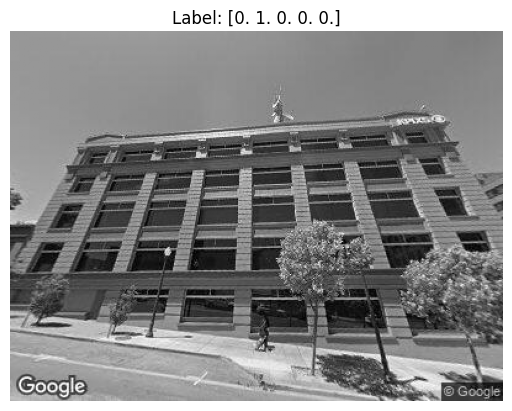

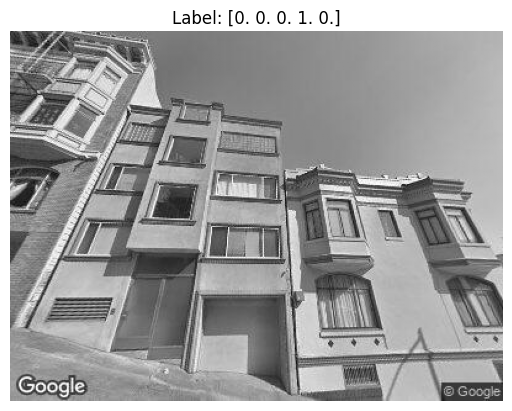

In [4]:
def display_image_with_label(image, label):
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title(f"Label: {label}")
    plt.show()

# Displaying an image from the training set
train_index = 20 # Change this to display a different image
display_image_with_label(X_train[train_index], y_train[train_index])

# Displaying an image from the validation set
val_index = 20  # Change this to display a different image
display_image_with_label(X_val[val_index], y_val[val_index])

In [5]:
# Compute class weights
y_train_classes = np.argmax(y_train, axis=1) + 1  # Convert back to class labels (1-5)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)
class_weights = {i: weight for i, weight in enumerate(class_weights)}


In [6]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
X_train = np.squeeze(X_train)
# Fit the generator
datagen.fit(X_train)

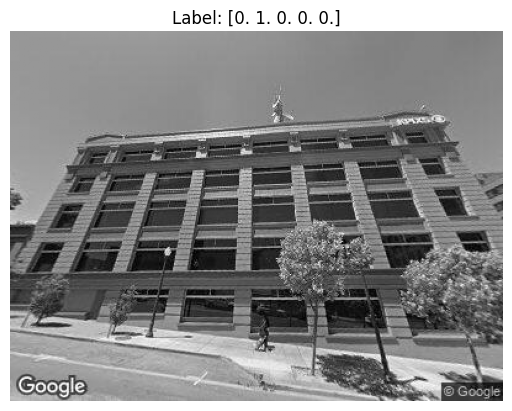

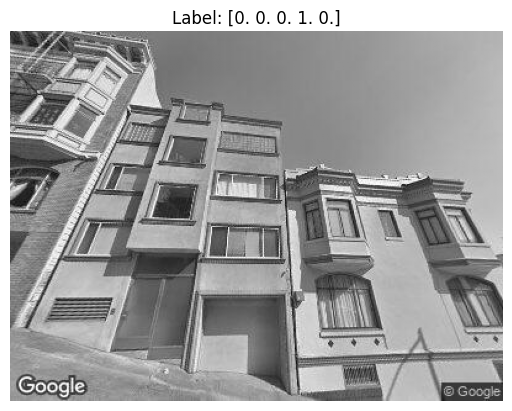

In [7]:
def display_image_with_label(image, label):
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title(f"Label: {label}")
    plt.show()

# Displaying an image from the training set
train_index = 20
display_image_with_label(X_train[train_index], y_train[train_index])

# Displaying an image from the validation set
val_index = 20  
display_image_with_label(X_val[val_index], y_val[val_index])

In [8]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_sum(loss, axis=-1)
    return focal_loss_fixed

In [9]:
def create_hybrid_model(input_shape=(300, 400, 3), num_classes=5):
    # Initialize the EfficientNet Backbone without the top layer
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Input layer
    inputs = Input(shape=input_shape)

    # EfficientNet for feature extraction
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)

    # Additional Dense layers with stronger dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)  
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Instantiate the model
model = create_hybrid_model()
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 400, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 10, 13, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 4,336,769 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [10]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=focal_loss(gamma=2.0, alpha=0.25), metrics=['accuracy'])

In [11]:
# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [12]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=20,
                    class_weight=class_weights,
                    callbacks=[lr_scheduler, early_stopping])


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728321197.949913     105 service.cc:145] XLA service 0x7a2338013dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728321197.949984     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728321197.949992     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728321259.534121     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.3402 - loss: 0.6334 - val_accuracy: 0.0833 - val_loss: 0.5886 - learning_rate: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 742ms/step - accuracy: 0.5392 - loss: 0.4234 - val_accuracy: 0.2897 - val_loss: 0.4761 - learning_rate: 0.0010
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 742ms/step - accuracy: 0.5185 - loss: 0.3322 - val_accuracy: 0.0833 - val_loss: 0.4245 - learning_rate: 0.0010
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 742ms/step - accuracy: 0.6002 - loss: 0.2390 - val_accuracy: 0.2897 - val_loss: 0.3611 - learning_rate: 0.0010
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 743ms/step - accuracy: 0.6099 - loss: 0.1987 - val_accuracy: 0.1806 - val_loss: 0.3579 - learning_rate: 0.0010
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 741ms/step - accuracy: 0.6497 - loss: 0.1662 - val_accuracy: 0.2560 - val_loss: 0.3028 - learning_rate: 0.0010
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 733ms/step - accuracy: 0.6601 - loss: 0.1461 - val_ac

In [16]:
def load_test_images(directory):
    images = []
    img_ids = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        images.append(img)
        img_ids.append(int(img_name.split('.')[0]))

    return np.array(images), img_ids

X_test, test_ids = load_test_images(test_dir)
X_test = X_test / 255.0  # Normalize the images

# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) + 1  

# Create submission file
submission = pd.DataFrame({'ID': test_ids, 'Predictions': y_pred_classes})
submission.sort_values(by='ID', inplace=True)
submission.to_csv('Code2.csv', index=False)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


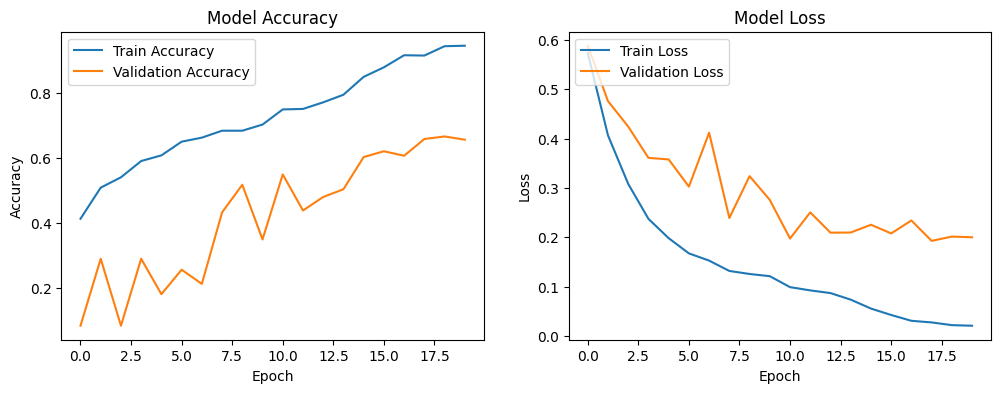

In [17]:
# Plot training & validation accuracy & loss values
def plot_history(history):
    
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()

# Call the plot function
plot_history(history)